<a href="https://colab.research.google.com/github/metadatadriven/PSI-VIZ/blob/main/PSI_WWed_20210908.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PSI Wonderful Wednesday Challenge Sep 2021

The September 2021 [PSI Wonderful Wednesday](https://www.psiweb.org/sigs-special-interest-groups/visualisation/welcome-to-wonderful-wednesdays) challenge is an analysis of [Continuous Glucose Monitoring (CGM) data](https://github.com/VIS-SIG/Wonderful-Wednesdays/tree/master/data/2021/2021-08-11)

> The goal of the challenge is to produce an explanatory graphics - Visually demonstrate that there is a dose response in glycemic control for Rx (the higher the dose the lower the variability) and that the Rx med and Rx high demonstrate better glycemic control that SOC and these attributes are sustained

## Setup compute environment

- Google Colab notebook
- Python & libraries

In [38]:
!python --version

<IPython.core.display.Javascript object>

Python 3.7.11


In [39]:
# Google Colab interactive data table
%load_ext google.colab.data_table

<IPython.core.display.Javascript object>

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [40]:
# load python libraries
import pandas as pd
from google.colab import data_table
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# initialise seaborn
sns.set()

<IPython.core.display.Javascript object>

In [41]:
# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)


<IPython.core.display.Javascript object>

## Load the Continuous Glucose Monitoring (CGM) data

The raw data is downloaded from the VIS-SIG github repo

In [42]:
# The source data is on GitHub, so lets get a local copy
!curl --remote-name \
     -H 'Accept: application/vnd.github.v3.raw' \
     --location https://raw.githubusercontent.com/VIS-SIG/Wonderful-Wednesdays/master/data/2021/2021-08-11/simulated_data.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 21.3M  100 21.3M    0     0  56.5M      0 --:--:-- --:--:-- --:--:-- 56.6M


According to the documentation, the dataset contains the following fields:

- SUBJID Subject Identification
- TREATMENT Treatment Regimen. Values = “Rx low”, “Rx medium” and “Rx high” and “SOC”
- VISITNUM Study visit number. Values = “3” (baseline), “17” (26 weeks) and “21” (52 weeks)
- DAY Day the CGM was measured. Values = integers
- TIME Time of the day that the CGM value was measured i.e. 0:00, 0:05, 0:10,..23:50, 23:55
- VALUE CGM value for that visit/day/time. Values = Real numbers

⚠️ **NOTE** that the VIS-SIG repo defines the data as containing 'VALUE CGM' but in actual dataset we have two possible CGM values:
- Original_CGMValue
- Simulated_CGMValue

It is not clear from the data nor the column heading which of these is the CGM Value to be analysed

In [43]:
# load the dataset csv file into Pandas - use the types given in the documentation
raw = pd.read_csv ('/content/simulated_data.csv', 
                  dtype={'SUBJID'             : 'category',
                         'TREATMENT'          : 'category',
                         'VISITNUM'           : 'category',
                         'CGMTIME'            : 'category',
                         'CGMDAY'             : 'int64',
                         'Original_CGMValue'  : 'float64',
                         'Simulated_CGMValue' : 'float64',
                         })

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
# Lets look at a summary of the dataset to see if CGM Values are the same or not
raw.describe()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,CGMDAY,Original_CGMValue,Simulated_CGMValue
count,658013.000000,658013.000000,658013.000000
mean,3.511422,153.713004,153.209121
std,1.115995,55.293595,54.633061
min,1.000000,39.000000,39.000000
25%,3.000000,114.000000,113.880000
50%,4.000000,140.000000,145.390000
75%,5.000000,180.000000,184.870000
max,5.000000,401.000000,401.000000


🔥 There is a difference between the two - the simulated value has higher values than the original value.

Select which variable to analyse:

In [45]:
#@title Select the raw variable to use as analysis value

# create a DF that contains a derived column called CGMVALUE - this is the
# analysis variable. 
df = raw[['SUBJID','TREATMENT','VISITNUM','CGMTIME','CGMDAY']].copy()

AVAL = "Simulated_CGMValue" #@param ["Simulated_CGMValue", "Original_CGMValue"]
df['AVAL'] = raw[AVAL]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data quality and cleaning

Two questions to investgate here: 1) are there any duplicate records? and 2) are there any missing values?

In [46]:
# List all duplicates by subject, visit and timepoint

df[df.duplicated(keep=False, subset=['SUBJID', 'VISITNUM', 'CGMDAY', 'CGMTIME'])]
# keep=FALSE means that all duplicate records are listed

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,SUBJID,TREATMENT,VISITNUM,CGMTIME,CGMDAY,AVAL
92,1006,Rx low,3,7:40,2,170.09
93,1006,Rx low,3,7:40,2,97.29
97,1006,Rx low,3,8:05,2,146.34
98,1006,Rx low,3,8:05,2,102.54
104,1006,Rx low,3,8:40,2,164.66
...,...,...,...,...,...,...
640995,2767,Rx low,17,19:40,5,80.54
641363,2767,Rx low,21,2:20,3,66.86
641364,2767,Rx low,21,2:20,3,116.99
641370,2767,Rx low,21,2:50,3,131.67


🔥 **CLEAN DUPLICATE RESULTS**

The following code-block drops the duplicate records - use it to configure if and which records are dropped

In [47]:
#@title Drop duplicates results by subject and timepoint

#should we de-dup at all??
DEDUP = "Yes" #@param ["Yes", "No"]

# define how to dedup the data
METHOD = "Keep lowest" #@param ["Keep lowest", "Keep highest"]

# keys used to sort and dedup the dataset
KEY = ["SUBJID", "VISITNUM", "CGMDAY", "CGMTIME"]
SORTKEY = KEY + ["AVAL"]

# dedup : dataframe list string -> dataframe
# function that de-duplicates a dataframe
def dedup(df, KEY, SORTKEY) :
  # keep lowest => order by AVAL ascending with NaN at the end
  df_sort = df.sort_values(by=SORTKEY,
                         ascending = (METHOD == "Keep lowest"), 
                         na_position = "last")
  # remove duplicates - keep the first one which will mean the highest
  # or lowest depending on the METHOD used to sort the data
  df_dedup = df_sort.drop_duplicates (subset=KEY, keep='first')
  return df_dedup

# Apply the logic.. are we removing dups or not?

if (DEDUP == "Yes"):
  df_post = dedup(df, KEY, SORTKEY)
  # how many did we drop?
  num_dropped = df.shape[0]-df_post.shape[0]
  print("Dropped %s records" % num_dropped)
  print("Method: ", METHOD)
else:
  print("No duplicates removed. Dataset pass-through.")
  df_post = df;

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropped 1192 records
Method:  Keep lowest


In [48]:
# are there any missing values in the raw data ?
raw.isnull().sum()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SUBJID                0
TREATMENT             0
VISITNUM              0
CGMTIME               0
CGMDAY                0
Original_CGMValue     0
Simulated_CGMValue    0
dtype: int64

No missing values in raw data, so no further action taken. Note that there may be missed visits.. what we have checked here is that there are no missing values in the collected data.

## Prepare data for vizualisation

In this section, we are going to prepare the data for a vizualisation with reference to [CDISC ADaM Supplement to the TAUG-Diabetes Version 1.0](https://www.cdisc.org/system/files/members/standard/ta/taug-diabetes-adam-supplement.pdf) 

Section 5.2.2 uses the following ARM metadata programming statement:

~~~
PROC MEANS DATA = ADSMBG; where <selection criteria>;  
 CLASS TRTP ATPT;  
 VAR AVAL ; 
 output out=means mean=mean stderr=stderr;  
 RUN ; 
~~~

In terms of variables, we already have TRTP (i.e.TREATMENT), and AVAL (i.e. Simulated_CGMValue or Original_CMGValue depending on selection earlier in notebook).

So the only variable to consider is ATPT (Anlysis timepoint). In the following codeblock we derive a single timepoint variable that is a combination of the CGMDAY and CGMTIME. CGM is monitored over multiple days per visit (e.g. Baseline visits are monitored over study day 2 and 3, so we want to be able to differentiate the 10:15 sample on day 2 from the 10:15 sample on day 3)

- 02:10:15 => 10:15 sample on Day 2 
- 03:10:15 => 10:15 sample on Day 3

In [49]:
# create a ATPT that is a combination of CGM date and time
# note that both the day and time are left padded with 0s
# so make them easier to sort 
_day = df_post.CGMDAY.astype('str').str.pad(width=2, side='left', fillchar='0')
_time = df_post.CGMTIME.astype('str').str.pad(width=5, side='left', fillchar='0')
df_post['ATPT'] = _day + ':' + _time

# have a quick look..
df_post.ATPT.unique()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array(['02:00:00', '02:00:05', '02:00:10', ..., '01:09:45', '01:09:50',
       '01:09:55'], dtype=object)

In [50]:
# while we are at it, lets define an AVISIT that has a text name for VISITNUM

# use a dictionary to lookup visitnum
AVISIT = {
    '3'  : 'Baseline',
    '17' : '26 Weeks',
    '21' : '52 Weeks'
}
# create AVISIT var
df_post['AVISIT'] = df['VISITNUM'].replace(AVISIT)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
# Now, apply the statistical analysis - i.e 8-point stats by visit and treatment 
df_stats = df_post.groupby(['AVISIT', 'TREATMENT'])[['AVAL']].describe().reset_index()
df_stats

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AVISIT  TREATMENT     AVAL  ...                           
                           count  ...      50%       75%     max
0   26 Weeks    Rx high  63206.0  ...  125.930  147.3375  262.28
1   26 Weeks     Rx low  56945.0  ...  137.920  165.1500  319.23
2   26 Weeks  Rx medium  39294.0  ...  128.420  149.9100  289.00
3   26 Weeks        SOC  44961.0  ...  142.180  174.5600  344.01
4   52 Weeks    Rx high  56846.0  ...  116.920  144.1675  306.85
5   52 Weeks     Rx low  52681.0  ...  133.890  159.6800  306.60
6   52 Weeks  Rx medium  46902.0  ...  121.620  142.7700  259.83
7   52 Weeks        SOC  43662.0  ...  145.075  180.9900  382.00
8   Baseline    Rx high  77820.0  ...  190.450  233.0100  401.00
9   Baseline     Rx low  67326.0  ...  188.790  234.3275  401.00
10  Baseline  Rx medium  50309.0  ...  174.020  209.8900  401.00
11  Baseline        SOC  56869.0  ...  182.940  220.2900  401.00

[12 rows x 10 columns]

In [52]:
# Now, do the detailed stats - i.e 8-point stats by visit, treatment and timepoint
df_stats_bytpt = df_post.groupby(['AVISIT', 'TREATMENT', 'ATPT'])[['AVAL']].describe().reset_index()
df_stats_bytpt

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AVISIT TREATMENT      ATPT  AVAL  ...                                     
                                    count  ...       25%      50%       75%     max
0      26 Weeks   Rx high  02:00:00  54.0  ...  110.3550  128.025  142.7050  218.56
1      26 Weeks   Rx high  02:00:05  54.0  ...   99.5900  121.550  136.5700  169.98
2      26 Weeks   Rx high  02:00:10  55.0  ...  101.4100  118.710  126.7950  165.69
3      26 Weeks   Rx high  02:00:15  55.0  ...   99.1300  114.410  143.1400  197.17
4      26 Weeks   Rx high  02:00:20  55.0  ...  107.9250  119.010  134.7000  170.29
...         ...       ...       ...   ...  ...       ...      ...       ...     ...
14097  Baseline       SOC  05:23:35  51.0  ...  160.0250  195.790  233.5850  294.07
14098  Baseline       SOC  05:23:40  51.0  ...  155.0350  188.720  226.1000  290.16
14099  Baseline       SOC  05:23:45  51.0  ...  152.0800  185.920  210.9050  312.52
14100  Baseline       SOC  05:23:50  50.0  ...  153.5175  168.120  188.6050  291.12
14101  Baseline       SOC  05:23:55  50.0  ...  159.3625  183.840  222.5525  317.62

[14102 rows x 11 columns]

## Vizualisation

The following figures present a summary of the Simulated CGM data by treatment arm and visit

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

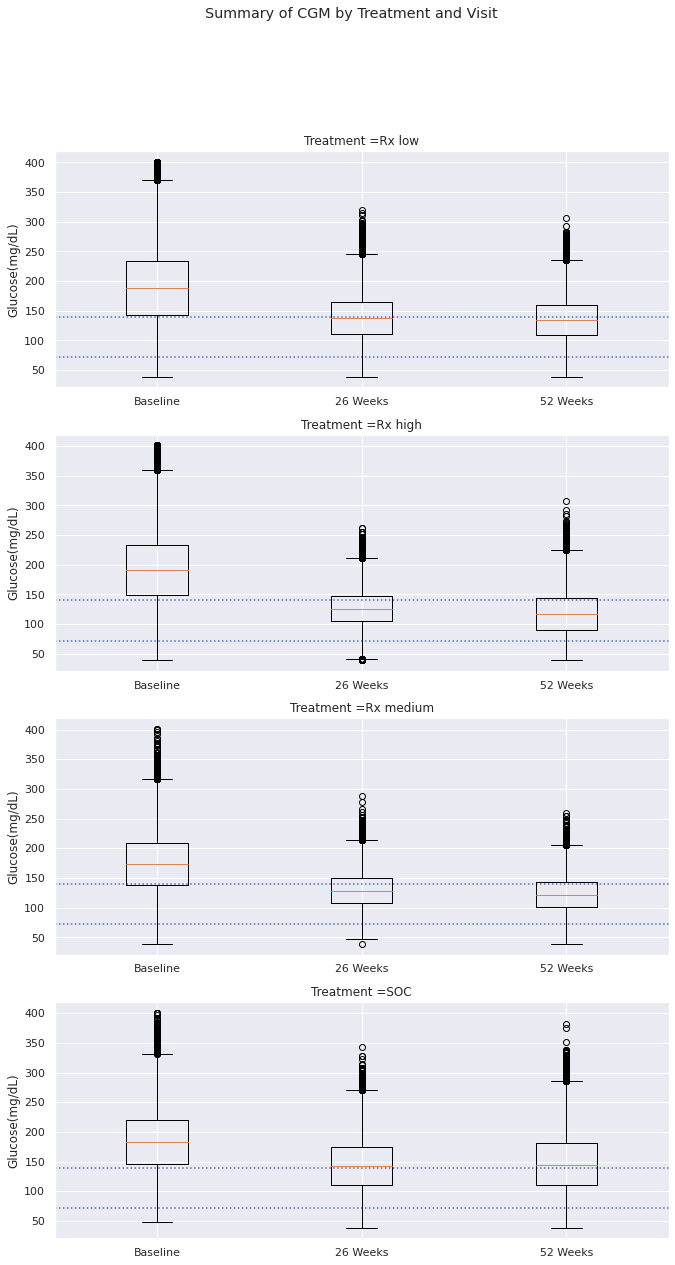

In [53]:
#@title Boxplot of CGM by treatment and visit

# modify the FIGSIZE to change size of plot
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(11,20))

fig.suptitle("Summary of CGM by Treatment and Visit")

for i, TRT in enumerate(df_post.TREATMENT.unique()):
  # set the titles, etc.
  ax[i].set_title('Treatment =' + TRT)
  ax[i].set_ylabel('Glucose(mg/dL)')
  ax[i].set_xticklabels(["Baseline", "26 Weeks", "52 Weeks"])
  # add the reference ranges taken from the github README document
  ax[i].axhline(72, color='b', linestyle=':')
  ax[i].axhline(140, color='b', linestyle=':')

  # subset the data for this treatment
  data1 = df_post[(df_post.TREATMENT==TRT) & (df_post['AVISIT']=="Baseline")].AVAL
  data2 = df_post[(df_post.TREATMENT==TRT) & (df_post['AVISIT']=="26 Weeks")].AVAL
  data3 = df_post[(df_post.TREATMENT==TRT) & (df_post['AVISIT']=="52 Weeks")].AVAL
  # ..boxplot the data
  ax[i].boxplot(np.array([data1, data2, data3], dtype=object))
#  ax[i].violinplot(data1)
#  ax[i].violinplot(data2)
#  ax[i].violinplot(data3)


# show after subplots have been created
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

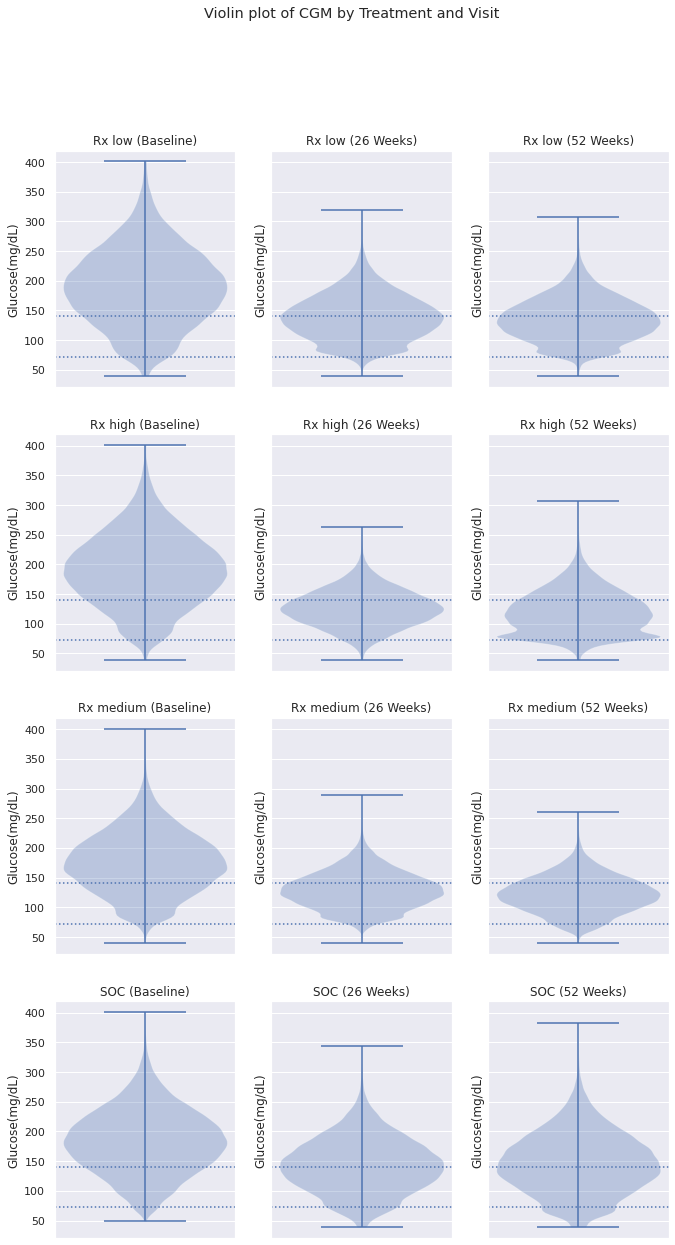

In [54]:
#@title Distribution of CGM by treatment and visit

# modify the FIGSIZE to change size of plot
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(11,20), sharey=True)

fig.suptitle("Violin plot of CGM by Treatment and Visit")
#fig.text(.5,0.95,'Subtitle here', fontsize=15, ha='center')

# switch off the xaxis ticks - dont need them cos one violin per subplot
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.xticks([])

for i, TRT in enumerate(df_post.TREATMENT.unique()):
  for j, VIS in enumerate(['Baseline', '26 Weeks', '52 Weeks']):
    # set the titles, etc.
    ax[i,j].set_title(TRT + ' (' + VIS + ')')
    ax[i,j].set_ylabel('Glucose(mg/dL)')
    # add the reference ranges taken from the github README document
    ax[i,j].axhline(72, color='b', linestyle=':')
    ax[i,j].axhline(140, color='b', linestyle=':')
    ax[i,j].set_xticks([])
    # subset the data for this treatment and visit
    data1 = df_post[(df_post.TREATMENT==TRT) & (df_post['AVISIT']==VIS)].AVAL
    # ..and plot it
    ax[i,j].violinplot(data1)

# show after subplots have been created
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

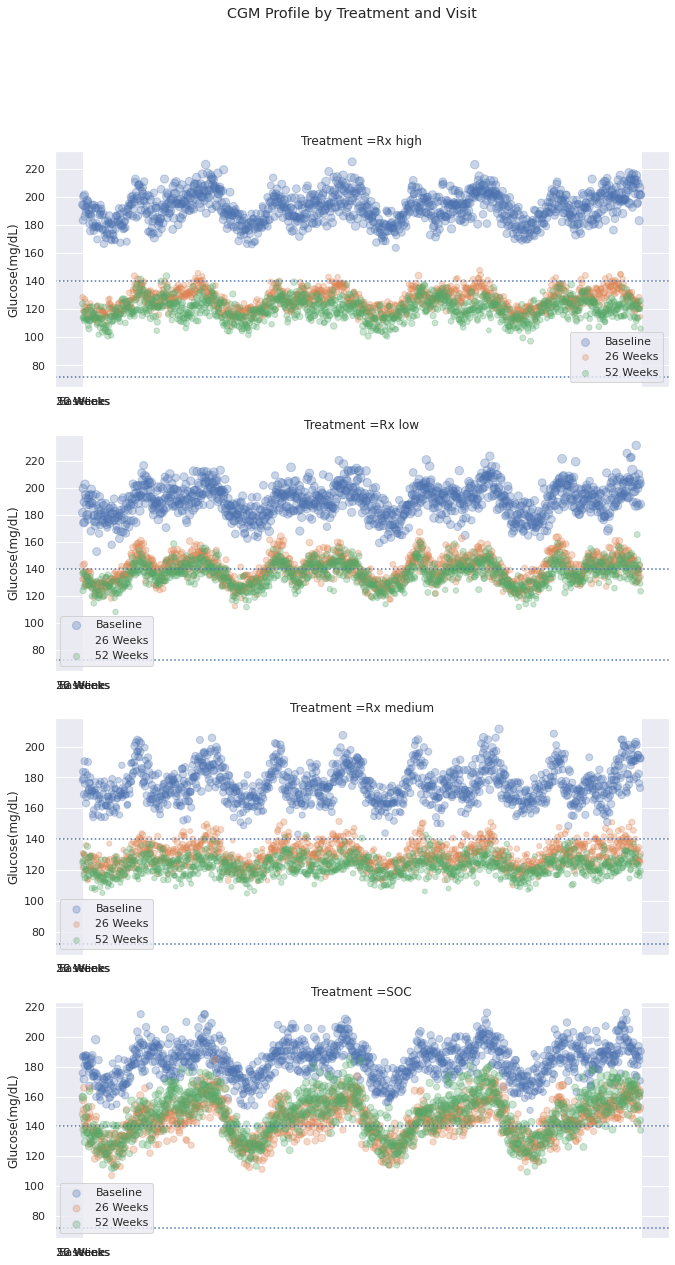

In [55]:
#@title CGM Profile by treatment and visit

# modify the FIGSIZE to change size of plot
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(11,20))

fig.suptitle("CGM Profile by Treatment and Visit")

# get a local copy of data to plot - change this to plot something else!
d = df_stats_bytpt

# loop through each treatment arm
for i, TRT in enumerate(d.TREATMENT.unique()):
  # set the titles, etc.
  ax[i].set_title('Treatment =' + TRT)
  ax[i].set_ylabel('Glucose(mg/dL)')
  ax[i].set_xticklabels(["Baseline", "26 Weeks", "52 Weeks"])
  # add the reference ranges taken from the github README document
  ax[i].axhline(72, color='b', linestyle=':')
  ax[i].axhline(140, color='b', linestyle=':')

  # subset the data for this treatment
  data1 = d[(d.TREATMENT==TRT) & (d['AVISIT']=="Baseline")]
  data2 = d[(d.TREATMENT==TRT) & (d['AVISIT']=="26 Weeks")]
  data3 = d[(d.TREATMENT==TRT) & (d['AVISIT']=="52 Weeks")]
  # ..boxplot the data
  ax[i].scatter(data1.ATPT, data1.AVAL['mean'], s=data1.AVAL['std'] ,alpha=0.3, label="Baseline")
  ax[i].scatter(data2.ATPT, data2.AVAL['mean'], s=data2.AVAL['std'] ,alpha=0.3, label="26 Weeks")
  ax[i].scatter(data3.ATPT, data3.AVAL['mean'], s=data3.AVAL['std'] ,alpha=0.3, label="52 Weeks")
  ax[i].legend()

# show after subplots have been created
plt.show()